In [6]:
import numpy as np
import matplotlib.pyplot as plt

#### 实现k-means聚类算法

In [7]:
def k_means(X,k,u0=None,MaxIte=30):
    # k-means聚类算法
    # 输入：
    #    X:样本数据，m×n数组
    #    k:聚类簇数目
    #    u0:初始聚类中心
    #    MaxIte:最大迭代次数
    # 输出:
    #    u:最终的聚类中心
    #    C:各个样本所属簇号
    #    erro:按(9.24)式计算的平方方差结果
    #    step:迭代次数
    
    m,n=X.shape   #样本数和特征数
    if u0==None:  #随机选取k个样本作为初始中心点
        u0=X[np.random.permutation(m)[:k],:] 
    u=u0.copy()
    step=0
    #print('D维度',X.shape,'u=',u)
    while True:
        
        step+=1
        u_old=u.copy()            #上一次迭代的中心点
        dist=np.zeros([m,k])      #存储各个样本到中心点的距离
        for kk in range(k):       #计算距离
            dist[:,kk]=np.sqrt(np.sum((X-u[kk])**2,axis=1))
        C=np.argmin(dist,axis=1)  #以距离最小的中心点索引号最为簇类号
        #print(u,C)
        for kk in range(k):       #更新聚类中心
            u[kk]=X[C==kk,:].mean(axis=0)  
        if (u==u_old).all():      #如果聚类中心无变化，则退出迭代
            break
        if step>MaxIte:           #如果超过最大迭代次数，则退出迭代
            print('超过最大迭代次数')
            break
    #=====计算平方误差(9.24)
    erro=0
    for kk in range(k):
         erro+=((X[C==kk]-u[kk])**2).sum()
    return u,C,erro,step

#### 计算衡量聚类性能的内部指标DBI和DI指数

In [8]:
def Inner_Index(X,u):
    #计算衡量聚类性能的内部指标DBI和DI指数
    m,n=X.shape
    k=u.shape[0]
    dist=np.zeros([m,k])      #存储各个样本到中心点的距离
    for kk in range(k):       #计算距离
        dist[:,kk]=np.sqrt(np.sum((X-u[kk])**2,axis=1))
    C=np.argmin(dist,axis=1)  #以距离最小的中心点索引号最为簇类号
    #===计算avg和diam
    avg=[]                    #存储簇内平均距离
    diam=[]                   #存储簇内最远距离
    for kk in range(k):
        Xkk=X[C==kk]          #第kk个聚类簇内的样本点
        mk=len(Xkk)
        if mk<=1:
            avg.append(0)
            diam.append(0)
            continue
        dist=[]               #存储簇内两个不同样本之间的距离
        for i in range(mk):
            for j in range(i+1,mk):
                dist.append(np.sqrt(((Xkk[i]-Xkk[j])**2).sum()))
        avg.append(np.mean(dist))
        #print('dist=',dist,'mk=',mk)
        diam.append(np.max(dist))
    #===计算DB指数
    DBIij=np.zeros([k,k])    #存储 [avg(Ci)+avg(Cj)]/dcen(ui,uj)
    for i in range(k):
        for j in range(i+1,k):
            DBIij[i,j]=(avg[i]+avg[j])/np.sqrt(((u[i]-u[j])**2).sum())
            DBIij[j,i]=DBIij[i,j]
    DBI=np.mean(np.max(DBIij,axis=1))
    #===计算Dunn指数
    dmin=[]    #存储Ci和Cj之间的最短距离
    for i in range(k):
        for j in range(i+1,k):
            Xi=X[C==i]
            Xj=X[C==j]
            dmin_ij=[]
            for xi in Xi:
                for xj in Xj:
                    dmin_ij.append(np.sqrt(((xi-xj)**2).sum()))
            dmin.append(min(dmin_ij))
    DI=min(dmin)/max(diam)
    
    return DBI,DI

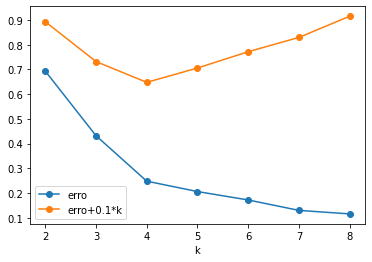

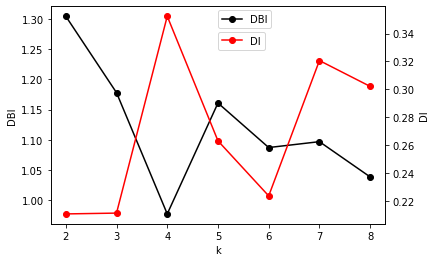

In [9]:

#================================================
#                  主程序
#================================================

#==============西瓜数据集4.0======================
D=np.array(
        [[0.697,0.460],[0.774,0.376],[0.634,0.264],[0.608,0.318],[0.556,0.215],
         [0.403,0.237],[0.481,0.149],[0.437,0.211],[0.666,0.091],[0.243,0.267],
         [0.245,0.057],[0.343,0.099],[0.639,0.161],[0.657,0.198],[0.360,0.370],
         [0.593,0.042],[0.719,0.103],[0.359,0.188],[0.339,0.241],[0.282,0.257],
         [0.748,0.232],[0.714,0.346],[0.483,0.312],[0.478,0.437],[0.525,0.369],
         [0.751,0.489],[0.532,0.472],[0.473,0.376],[0.725,0.445],[0.446,0.459]])
m=D.shape[0]

#======考察平方误差(9.24式)随k值的变化规律=======
# 结果如预期，平方误差随k值增加而减小
# 如果加上一个惩罚项 0.1*k，出现抛物线
# 考察DBI评分(9.12式)随k值的变化规律
erros=[]
DBIs=[]
DIs=[]
ks=range(2,8+1)         #考察k=2~8
for k in ks:    
    DBI=[]
    DI=[]  
    erro=[]
    for i in range(5):  #对于每个k值，初始5次聚类，取其中最佳者
        u,C,erro_i,step=k_means(D,k)
        erro.append(erro_i)
        DBi,Di=Inner_Index(D,u)
        DBI.append(DBi)
        DI.append(Di)
    erros.append(min(erro))
    DBIs.append(min(DBI))
    DIs.append(max(DI))
plt.figure()
plt.plot(ks,erros,'o-')
plt.plot(ks,0.1*np.array(ks)+np.array(erros),'o-')
plt.xlabel('k')
plt.legend(['erro','erro+0.1*k'])
plt.show()


#======考察DBI评分(9.12式)随k值的变化规律=======
# 绘制计算结果
ax1=plt.figure().add_subplot(111)
ax2=ax1.twinx()    #双y坐标

ax1.plot(ks,DBIs,'o-k',label='DBI')
ax2.plot(ks,DIs,'o-r',label='DI')

ax1.set_xlabel('k')
ax1.set_ylabel('DBI')
ax2.set_ylabel('DI')

ax1.legend(loc=(0.5,.9))
ax2.legend(loc=(0.5,.8))

plt.show()